In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json
import evaluate
import tqdm

/data/katie_kang/miniconda3/envs/trlx2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-07-10 22:11:22,533] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
rouge = evaluate.load('rouge')

In [55]:
train_num_correct = (np.concatenate([np.load("data/MATH_aug/train_aug_1_answer_types5_seed2.npy"), np.load("data/MATH_aug/train_aug_2_answer_types5_seed2.npy")], axis=0)==0).sum(axis=-1)
hard_train_idxs = np.where(train_num_correct==0)[0]
easy_train_idxs = np.where(train_num_correct==5)[0]
medium_train_idxs = np.where((train_num_correct<5)*(train_num_correct>0))[0] 

In [7]:
with open('data/MATH_aug/AugMATH_part1.jsonl', 'r') as json_file:
    json_list = list(json_file)

with open('data/MATH_aug/AugMATH_part2.jsonl', 'r') as json_file:
    json_list += list(json_file)

train_questions = []
train_answers = []
for json_str in json_list:
    result = json.loads(json_str)
    train_questions.append(result["query"])
    train_answers.append(result["response"])
    
train_questions = np.array(train_questions)
train_answers = np.array(train_answers)

In [30]:
NUM_TRAIN_POINTS=20000
HARD_RATIO = 1
EASY_RATIO=(1-HARD_RATIO)*0.35
MEDIUM_RATIO=(1-HARD_RATIO)*0.65


CKPT_NAME=f"math_aug_easy{EASY_RATIO:.2f}_medium{MEDIUM_RATIO:.2f}_hard{HARD_RATIO:.2f}_total{NUM_TRAIN_POINTS}"

subsample_idxs = np.load("ckpts/"+CKPT_NAME+"/subsample_idxs.npy")[:5000]

rouges_hard = []
ratios_hard = []
for checkpoint_strs in ["2000", "4000", "6000", "8000"]:
    train_correct = np.load("ckpts/"+CKPT_NAME+"/checkpoint-"+checkpoint_strs+"/train_aug_subsample_answer_types5_seed2.npy")==0
    train_samples = np.load("ckpts/"+CKPT_NAME+"/checkpoint-"+checkpoint_strs+"/train_aug_subsample_answers5_seed2.npy")


    incorrect = 0
    exact_match = 0
    correct_different = 0    
    
    predictions =[]
    references = []
    for input_idx in tqdm.tqdm(range(5000)):
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                # print(input_idx)
                # print(train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip())
                # print(train_answers[subsample_idxs[input_idx]])
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    exact_match+=1
                else:
                    correct_different+=1

                predictions.append(train_samples[input_idx][sample_idx].strip())
                references.append(train_answers[subsample_idxs[input_idx]].strip())
                    # print(input_idx)
                    # print(train_samples[input_idx][sample_idx])
                    # print(train_answers[subsample_idxs[input_idx]])
                    # print("\n")
            else:
                incorrect+=1
    
    # results = rouge.compute(predictions=predictions, references=references, use_aggregator=False)
    # rouges_hard.append(results['rougeL'])
    total = exact_match+correct_different+incorrect
    print(exact_match/total, correct_different/total, incorrect/total)
    ratios_hard.append([exact_match/total, correct_different/total, incorrect/total])

100%|██████████| 5000/5000 [00:00<00:00, 118943.48it/s]


0.00156 0.03496 0.96348


100%|██████████| 5000/5000 [00:00<00:00, 43867.78it/s]


0.02412 0.10288 0.873


100%|██████████| 5000/5000 [00:00<00:00, 16362.63it/s]


0.17496 0.18912 0.63592


100%|██████████| 5000/5000 [00:00<00:00, 9292.76it/s]

0.50892 0.1448 0.34628


In [13]:
rouges_list = rouges_hard
rouges_dict = {}
rouges_dict['2000'] = rouges_list[0]
rouges_dict['4000'] = rouges_list[1]
rouges_dict['6000'] = rouges_list[2]
rouges_dict['8000'] = rouges_list[3]
np.save("ckpts/"+CKPT_NAME+"/rouges_dict.npy", rouges_dict)

In [42]:
rouges_dict = np.load("ckpts/"+CKPT_NAME+"/rouges_dict.npy", allow_pickle=True).item()

In [43]:
rouges_hard = [rouges_dict['2000'], rouges_dict['4000'], rouges_dict['6000'], rouges_dict['8000']]

In [56]:
NUM_TRAIN_POINTS=20000
HARD_RATIO = 0.75
EASY_RATIO=(1-HARD_RATIO)*0.35
MEDIUM_RATIO=(1-HARD_RATIO)*0.65


CKPT_NAME=f"math_aug_easy{EASY_RATIO:.2f}_medium{MEDIUM_RATIO:.2f}_hard{HARD_RATIO:.2f}_total{NUM_TRAIN_POINTS}"

subsample_idxs = np.load("ckpts/"+CKPT_NAME+"/subsample_idxs.npy")[:5000]


rouges_hard0pt75 = []
ratios_hard0pt75 = []
ratios_hard0pt75_easysubsample = []
ratios_hard0pt75_mediumsubsample = []
for checkpoint_strs in ["2000", "4000", "6000", "8000"]:

    train_correct = np.load("ckpts/"+CKPT_NAME+"/checkpoint-"+checkpoint_strs+"/train_aug_subsample_answer_types5_seed2.npy")==0
    train_samples = np.load("ckpts/"+CKPT_NAME+"/checkpoint-"+checkpoint_strs+"/train_aug_subsample_answers5_seed2.npy")
    hard_subsample = np.where(np.isin(subsample_idxs, hard_train_idxs))[0]
    easy_subsample = np.where(np.isin(subsample_idxs, easy_train_idxs))[0]
    medium_subsample = np.where(np.isin(subsample_idxs, medium_train_idxs))[0]

    incorrect = 0
    exact_match = 0
    correct_different = 0
    predictions =[]
    references = []
    for input_idx in hard_subsample:
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    exact_match+=1
                else:
                    correct_different+=1
                predictions.append(train_samples[input_idx][sample_idx].strip())
                references.append(train_answers[subsample_idxs[input_idx]].strip())
            else:
                incorrect+=1
    # results = rouge.compute(predictions=predictions, references=references, use_aggregator=False)
    # rouges_hard0pt75.append(results['rougeL'])

    total = exact_match+correct_different+incorrect
    print(total)
    print(exact_match/total, correct_different/total, incorrect/total)
    ratios_hard0pt75.append([exact_match/total, correct_different/total, incorrect/total])
    
    
    
    incorrect = 0
    exact_match = 0
    correct_different = 0
    predictions =[]
    references = []
    for input_idx in easy_subsample:
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    exact_match+=1
                else:
                    correct_different+=1
                predictions.append(train_samples[input_idx][sample_idx].strip())
                references.append(train_answers[subsample_idxs[input_idx]].strip())
            else:
                incorrect+=1
    # results = rouge.compute(predictions=predictions, references=references, use_aggregator=False)
    # rouges_hard0pt75.append(results['rougeL'])

    total = exact_match+correct_different+incorrect
    print(total)
    print(exact_match/total, correct_different/total, incorrect/total)
    ratios_hard0pt75_easysubsample.append([exact_match/total, correct_different/total, incorrect/total])
    
    
    incorrect = 0
    exact_match = 0
    correct_different = 0
    predictions =[]
    references = []
    for input_idx in medium_subsample:
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    exact_match+=1
                else:
                    correct_different+=1
                predictions.append(train_samples[input_idx][sample_idx].strip())
                references.append(train_answers[subsample_idxs[input_idx]].strip())
            else:
                incorrect+=1
    
    total = exact_match+correct_different+incorrect
    print(total)
    print(exact_match/total, correct_different/total, incorrect/total)
    ratios_hard0pt75_mediumsubsample.append([exact_match/total, correct_different/total, incorrect/total])

18870
0.0009009009009009009 0.03158452570217276 0.9675145733969264
2210
0.006787330316742082 0.3755656108597285 0.6176470588235294
3920
0.001530612244897959 0.12091836734693878 0.8775510204081632
18870
0.01181770005299417 0.08065712771595125 0.9075251722310546
2210
0.02760180995475113 0.5782805429864254 0.3941176470588235
3920
0.01683673469387755 0.22959183673469388 0.7535714285714286
18870
0.11192368839427663 0.17117117117117117 0.7169051404345522
2210
0.15701357466063348 0.6085972850678733 0.2343891402714932
3920
0.08903061224489796 0.3336734693877551 0.577295918367347
18870
0.40317965023847374 0.15877053524112347 0.43804981452040276
2210
0.4497737556561086 0.4502262443438914 0.1
3920
0.3153061224489796 0.3173469387755102 0.3673469387755102


In [19]:
rouges_list = rouges_hard0pt75
rouges_dict = {}
rouges_dict['2000'] = rouges_list[0]
rouges_dict['4000'] = rouges_list[1]
rouges_dict['6000'] = rouges_list[2]
rouges_dict['8000'] = rouges_list[3]
np.save("ckpts/"+CKPT_NAME+"/rouges_dict.npy", rouges_dict)

In [57]:
NUM_TRAIN_POINTS=20000
HARD_RATIO = 0.5
EASY_RATIO=(1-HARD_RATIO)*0.35
MEDIUM_RATIO=(1-HARD_RATIO)*0.65


CKPT_NAME=f"math_aug_easy{EASY_RATIO:.2f}_medium{MEDIUM_RATIO:.2f}_hard{HARD_RATIO:.2f}_total{NUM_TRAIN_POINTS}_ckpts"

subsample_idxs = np.load("ckpts/"+CKPT_NAME+"/subsample_idxs.npy")[:5000]


rouges_hard0pt5 = []
ratios_hard0pt5 = []
ratios_hard0pt5_easysubsample = []
ratios_hard0pt5_mediumsubsample = []
for checkpoint_strs in ["2000", "4000", "6000", "8000"]:

    train_correct = np.load("ckpts/"+CKPT_NAME+"/checkpoint-"+checkpoint_strs+"/train_aug_subsample_answer_types5_seed2.npy")==0
    train_samples = np.load("ckpts/"+CKPT_NAME+"/checkpoint-"+checkpoint_strs+"/train_aug_subsample_answers5_seed2.npy")
    hard_subsample = np.where(np.isin(subsample_idxs, hard_train_idxs))[0]
    easy_subsample = np.where(np.isin(subsample_idxs, easy_train_idxs))[0]
    medium_subsample = np.where(np.isin(subsample_idxs, medium_train_idxs))[0]

    incorrect = 0
    exact_match = 0
    correct_different = 0
    predictions =[]
    references = []
    for input_idx in hard_subsample:
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    exact_match+=1
                else:
                    correct_different+=1
                predictions.append(train_samples[input_idx][sample_idx].strip())
                references.append(train_answers[subsample_idxs[input_idx]].strip())
            else:
                incorrect+=1
    # results = rouge.compute(predictions=predictions, references=references, use_aggregator=False)
    # rouges_hard0pt75.append(results['rougeL'])

    total = exact_match+correct_different+incorrect
    print(total)
    print(exact_match/total, correct_different/total, incorrect/total)
    ratios_hard0pt5.append([exact_match/total, correct_different/total, incorrect/total])
     
    
    
    incorrect = 0
    exact_match = 0
    correct_different = 0
    predictions =[]
    references = []
    for input_idx in easy_subsample:
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    exact_match+=1
                else:
                    correct_different+=1
                predictions.append(train_samples[input_idx][sample_idx].strip())
                references.append(train_answers[subsample_idxs[input_idx]].strip())
            else:
                incorrect+=1
    # results = rouge.compute(predictions=predictions, references=references, use_aggregator=False)
    # rouges_hard0pt75.append(results['rougeL'])

    total = exact_match+correct_different+incorrect
    print(total)
    print(exact_match/total, correct_different/total, incorrect/total)
    ratios_hard0pt5_easysubsample.append([exact_match/total, correct_different/total, incorrect/total])
    
    
    incorrect = 0
    exact_match = 0
    correct_different = 0
    predictions =[]
    references = []
    for input_idx in medium_subsample:
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    exact_match+=1
                else:
                    correct_different+=1
                predictions.append(train_samples[input_idx][sample_idx].strip())
                references.append(train_answers[subsample_idxs[input_idx]].strip())
            else:
                incorrect+=1
    
    total = exact_match+correct_different+incorrect
    print(total)
    print(exact_match/total, correct_different/total, incorrect/total)
    ratios_hard0pt5_mediumsubsample.append([exact_match/total, correct_different/total, incorrect/total])

12645
7.908264136022143e-05 0.03107947805456702 0.9688414393040727
4380
0.0031963470319634705 0.3636986301369863 0.6331050228310502
7975
0.0008777429467084639 0.14858934169278998 0.8505329153605016
12645
0.007908264136022143 0.0686437327006722 0.9234480031633057
4380
0.03447488584474886 0.5472602739726027 0.4182648401826484
7975
0.010156739811912226 0.25329153605015675 0.736551724137931
12645
0.0653222617635429 0.15318307631474892 0.7814946619217081
4380
0.16598173515981735 0.6095890410958904 0.22442922374429225
7975
0.09605015673981192 0.3638871473354232 0.5400626959247649
12645
0.3125345986555951 0.16860419137999208 0.5188612099644128
4380
0.4041095890410959 0.4949771689497717 0.10091324200913242
7975
0.32225705329153603 0.34432601880877745 0.3334169278996865


In [22]:
rouges_list = rouges_hard0pt5
rouges_dict = {}
rouges_dict['2000'] = rouges_list[0]
rouges_dict['4000'] = rouges_list[1]
rouges_dict['6000'] = rouges_list[2]
rouges_dict['8000'] = rouges_list[3]
np.save("ckpts/"+CKPT_NAME+"/rouges_dict.npy", rouges_dict)

In [58]:
NUM_TRAIN_POINTS=20000
HARD_RATIO = 0.25
EASY_RATIO=(1-HARD_RATIO)*0.35
MEDIUM_RATIO=(1-HARD_RATIO)*0.65


CKPT_NAME=f"math_aug_easy{EASY_RATIO:.2f}_medium{MEDIUM_RATIO:.2f}_hard{HARD_RATIO:.2f}_total{NUM_TRAIN_POINTS}_ckpts"

subsample_idxs = np.load("ckpts/"+CKPT_NAME+"/subsample_idxs.npy")[:5000]


rouges_hard0pt25 = []
ratios_hard0pt25 = []
ratios_hard0pt25_easysubsample = []
ratios_hard0pt25_mediumsubsample = []
for checkpoint_strs in ["2000", "4000", "6000", "8000"]:

    train_correct = np.load("ckpts/"+CKPT_NAME+"/checkpoint-"+checkpoint_strs+"/train_aug_subsample_answer_types5_seed2.npy")==0
    train_samples = np.load("ckpts/"+CKPT_NAME+"/checkpoint-"+checkpoint_strs+"/train_aug_subsample_answers5_seed2.npy")
    hard_subsample = np.where(np.isin(subsample_idxs, hard_train_idxs))[0]
    easy_subsample = np.where(np.isin(subsample_idxs, easy_train_idxs))[0]
    medium_subsample = np.where(np.isin(subsample_idxs, medium_train_idxs))[0]

    incorrect = 0
    exact_match = 0
    correct_different = 0
    predictions =[]
    references = []
    for input_idx in hard_subsample:
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    exact_match+=1
                else:
                    correct_different+=1
                predictions.append(train_samples[input_idx][sample_idx].strip())
                references.append(train_answers[subsample_idxs[input_idx]].strip())
            else:
                incorrect+=1
    # results = rouge.compute(predictions=predictions, references=references, use_aggregator=False)
    # rouges_hard0pt75.append(results['rougeL'])

    total = exact_match+correct_different+incorrect
    print(total)
    print(exact_match/total, correct_different/total, incorrect/total)
    ratios_hard0pt25.append([exact_match/total, correct_different/total, incorrect/total])
    
    
    
    incorrect = 0
    exact_match = 0
    correct_different = 0
    predictions =[]
    references = []
    for input_idx in easy_subsample:
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    exact_match+=1
                else:
                    correct_different+=1
                predictions.append(train_samples[input_idx][sample_idx].strip())
                references.append(train_answers[subsample_idxs[input_idx]].strip())
            else:
                incorrect+=1
    # results = rouge.compute(predictions=predictions, references=references, use_aggregator=False)
    # rouges_hard0pt75.append(results['rougeL'])

    total = exact_match+correct_different+incorrect
    print(total)
    print(exact_match/total, correct_different/total, incorrect/total)
    ratios_hard0pt25_easysubsample.append([exact_match/total, correct_different/total, incorrect/total])
    
    
    incorrect = 0
    exact_match = 0
    correct_different = 0
    predictions =[]
    references = []
    for input_idx in medium_subsample:
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    exact_match+=1
                else:
                    correct_different+=1
                predictions.append(train_samples[input_idx][sample_idx].strip())
                references.append(train_answers[subsample_idxs[input_idx]].strip())
            else:
                incorrect+=1
    
    total = exact_match+correct_different+incorrect
    print(total)
    print(exact_match/total, correct_different/total, incorrect/total)
    ratios_hard0pt25_mediumsubsample.append([exact_match/total, correct_different/total, incorrect/total])

6325
0.0 0.028774703557312254 0.9712252964426877
6510
0.009523809523809525 0.38740399385560675 0.6030721966205838
12165
0.0009864364981504315 0.15207562679819153 0.846937936703658
6325
0.0018972332015810276 0.0425296442687747 0.9555731225296442
6510
0.041321044546850996 0.5523809523809524 0.4062980030721966
12165
0.008713522400328811 0.24463625154130703 0.7466502260583642
6325
0.0466403162055336 0.12221343873517787 0.8311462450592886
6510
0.2073732718894009 0.6193548387096774 0.17327188940092167
12165
0.1012741471434443 0.375914508836827 0.5228113440197287
6325
0.21739130434782608 0.16727272727272727 0.6153359683794466
6510
0.45130568356374806 0.4734254992319508 0.07526881720430108
12165
0.3613645704891081 0.33982737361282367 0.29880805589806825


In [24]:
rouges_list = rouges_hard0pt25
rouges_dict = {}
rouges_dict['2000'] = rouges_list[0]
rouges_dict['4000'] = rouges_list[1]
rouges_dict['6000'] = rouges_list[2]
rouges_dict['8000'] = rouges_list[3]
np.save("ckpts/"+CKPT_NAME+"/rouges_dict.npy", rouges_dict)

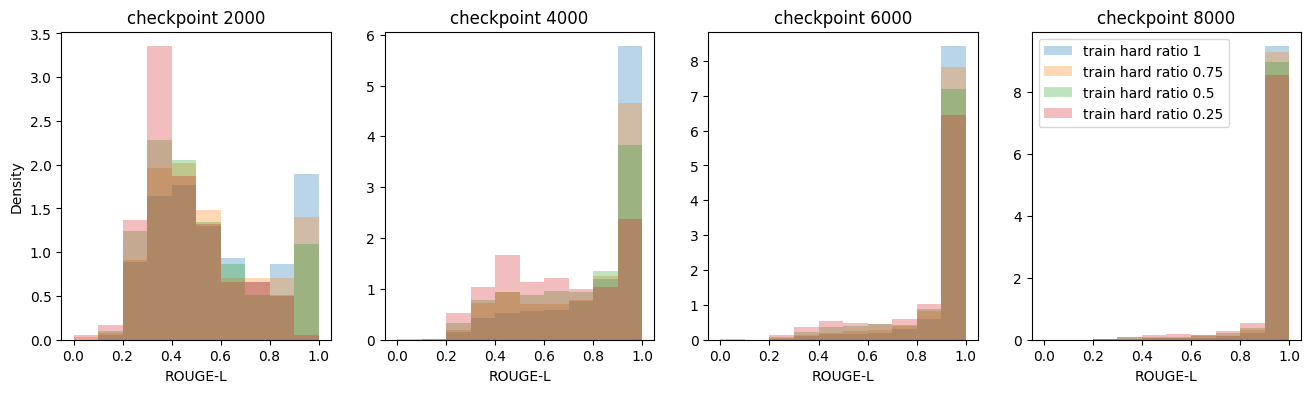

In [29]:
# make 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharex=True)


for i in range(4):
    axs[i].hist(rouges_hard[i], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], alpha=0.3, label=f"train hard ratio 1", density=True)
    axs[i].hist(rouges_hard0pt75[i], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], alpha=0.3, label=f"train hard ratio 0.75", density=True)
    axs[i].hist(rouges_hard0pt5[i], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], alpha=0.3, label=f"train hard ratio 0.5", density=True)
    axs[i].hist(rouges_hard0pt25[i], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], alpha=0.3, label=f"train hard ratio 0.25", density=True)

    axs[i].set_title(f"checkpoint {(i+1)*2000}")
    axs[i].set_xlabel("ROUGE-L")
    axs[0].set_ylabel("Density")
axs[3].legend()
plt.savefig("delete.jpg")




In [34]:
ratios_hard0pt25

[[0.0, 0.028774703557312254, 0.9712252964426877],
 [0.0018972332015810276, 0.0425296442687747, 0.9555731225296442],
 [0.0466403162055336, 0.12221343873517787, 0.8311462450592886],
 [0.21739130434782608, 0.16727272727272727, 0.6153359683794466]]

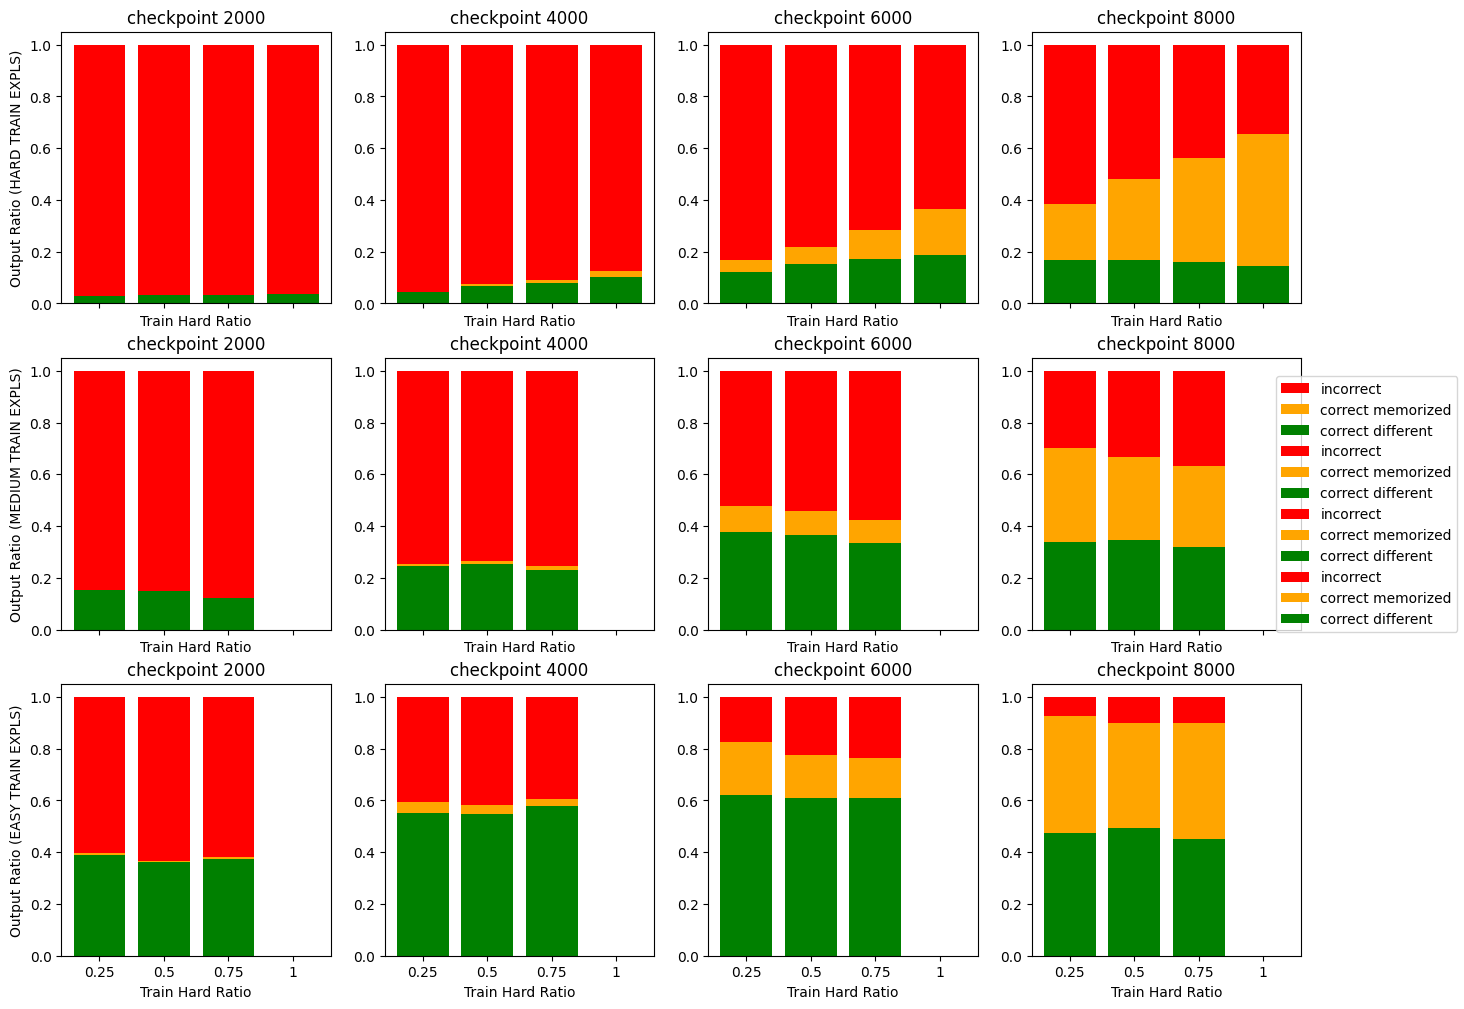

In [63]:
# [exact_match/total, correct_different/total, incorrect/total]

fig, axs = plt.subplots(3, 4, figsize=(16, 12), sharex=True)

j=0
for i in range(4):

    axs[j][i].bar([3], [1], color='r', label = "incorrect")
    axs[j][i].bar([3], [ratios_hard[i][1]+ratios_hard[i][0]], color='orange', label = "correct memorized")
    axs[j][i].bar([3], [ratios_hard[i][1]], color='g', label = "correct different")

    axs[j][i].bar([2], [1], color='r')
    axs[j][i].bar([2], [ratios_hard0pt75[i][1]+ratios_hard0pt75[i][0]], color='orange')
    axs[j][i].bar([2], [ratios_hard0pt75[i][1]], color='g')

    axs[j][i].bar([1], [1], color='r')
    axs[j][i].bar([1], [ratios_hard0pt5[i][1]+ratios_hard0pt5[i][0]], color='orange')
    axs[j][i].bar([1], [ratios_hard0pt5[i][1]], color='g')
    axs[j][i].bar([0], [1], color='r')
    axs[j][i].bar([0], [ratios_hard0pt25[i][1]+ratios_hard0pt25[i][0]], color='orange')
    axs[j][i].bar([0], [ratios_hard0pt25[i][1]], color='g')
    
    axs[j][i].set_title(f"checkpoint {(i+1)*2000}")
    axs[j][i].set_xticks([0, 1, 2, 3], ["0.25", "0.5", "0.75", "1"])
    axs[j][i].set_xlabel("Train Hard Ratio")
    axs[j][0].set_ylabel("Output Ratio (HARD TRAIN EXPLS)")
    
j=1
for i in range(4):

    axs[j][i].bar([2], [1], color='r')
    axs[j][i].bar([2], [ratios_hard0pt75_mediumsubsample[i][1]+ratios_hard0pt75_mediumsubsample[i][0]], color='orange')
    axs[j][i].bar([2], [ratios_hard0pt75_mediumsubsample[i][1]], color='g')

    axs[j][i].bar([1], [1], color='r')
    axs[j][i].bar([1], [ratios_hard0pt5_mediumsubsample[i][1]+ratios_hard0pt5_mediumsubsample[i][0]], color='orange')
    axs[j][i].bar([1], [ratios_hard0pt5_mediumsubsample[i][1]], color='g')
    axs[j][i].bar([0], [1], color='r')
    axs[j][i].bar([0], [ratios_hard0pt25_mediumsubsample[i][1]+ratios_hard0pt25_mediumsubsample[i][0]], color='orange')
    axs[j][i].bar([0], [ratios_hard0pt25_mediumsubsample[i][1]], color='g')
    
    axs[j][i].set_title(f"checkpoint {(i+1)*2000}")
    axs[j][i].set_xticks([0, 1, 2, 3], ["0.25", "0.5", "0.75", "1"])
    axs[j][i].set_xlabel("Train Hard Ratio")
    axs[j][0].set_ylabel("Output Ratio (MEDIUM TRAIN EXPLS)")


j=2
for i in range(4):

    axs[j][i].bar([2], [1], color='r')
    axs[j][i].bar([2], [ratios_hard0pt75_easysubsample[i][1]+ratios_hard0pt75_easysubsample[i][0]], color='orange')
    axs[j][i].bar([2], [ratios_hard0pt75_easysubsample[i][1]], color='g')

    axs[j][i].bar([1], [1], color='r')
    axs[j][i].bar([1], [ratios_hard0pt5_easysubsample[i][1]+ratios_hard0pt5_easysubsample[i][0]], color='orange')
    axs[j][i].bar([1], [ratios_hard0pt5_easysubsample[i][1]], color='g')
    axs[j][i].bar([0], [1], color='r')
    axs[j][i].bar([0], [ratios_hard0pt25_easysubsample[i][1]+ratios_hard0pt25_easysubsample[i][0]], color='orange')
    axs[j][i].bar([0], [ratios_hard0pt25_easysubsample[i][1]], color='g')
    
    axs[j][i].set_title(f"checkpoint {(i+1)*2000}")
    axs[j][i].set_xticks([0, 1, 2, 3], ["0.25", "0.5", "0.75", "1"])
    axs[j][i].set_xlabel("Train Hard Ratio")
    axs[j][0].set_ylabel("Output Ratio (EASY TRAIN EXPLS)")
    
    
    
fig.legend(loc='center right')


In [47]:
idxs  = np.where(np.array(rouges_hard[0])<1)[0]

(array([0.55362359, 0.76123244, 1.79927667, 1.17645013, 0.96884129,
        1.03804423, 0.83043539, 1.45326193, 1.52246488, 2.49130616]),
 array([0.20603015, 0.28542714, 0.36482412, 0.44422111, 0.52361809,
        0.60301508, 0.68241206, 0.76180905, 0.84120603, 0.92060302,
        1.        ]),
 <BarContainer object of 10 artists>)

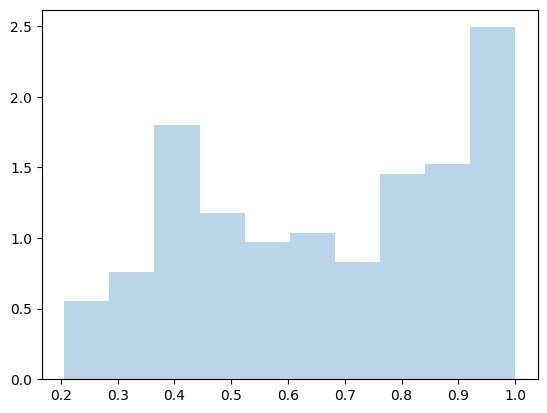

In [53]:
plt.hist(np.array(rouges_hard[1])[idxs], density=True, alpha=0.3)
# plt.hist(np.array(rouges_hard[2])[idxs])
# plt.hist(np.array(rouges_hard[3])[idxs])